In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import tadasets
from ripser import Rips
import persim
import seaborn as sns

In [2]:
def traj_computation(epsilon,a,b,Iext,theta,T,N,v0,w0,plot=1):
    def F(x):
        v,w = x
        dv  = v - (v**3)/3 - w + Iext
        dw  = epsilon*(v + a - b*w)
        return np.array([dv,dw])

    def J(x):
        v,w = x
        J11 = 1 - theta*dt*(1-v**2)
        J12 = dt*theta
        J21 = -dt*theta*epsilon
        J22 = 1 + dt*theta*b*epsilon
        return np.array([[J11,J12],[J21,J22]])

    def Newton(x,f,maxit,tol):
        i = 0
        converged = False
        x_old = x.copy()

        def g(x_current):
            return x_current - f(x_current)

        while not converged:
            i += 1
            Jacobian_g = J(x_old)
            delta_x = np.linalg.solve(Jacobian_g, -g(x_old))
            x_new = x_old + delta_x
            if i >= maxit or np.linalg.norm(g(x_new)) < tol or np.linalg.norm(delta_x) < tol:
                converged = True
            else:
                x_old = x_new.copy()

        return x_new

    dt    = T/N;
    tt    = np.linspace(0,T,N+1)
    x     = np.array([v0,w0])

    x_old = x.copy()
    for t in tt[1:]:
        C = x_old + dt*(1-theta)*F(x_old)
        def RHS(x):
            return C + dt*theta*F(x)
        x_new = Newton(x_old,RHS,10,1e-7)
        x = np.vstack((x,x_new))
        x_old = x_new.copy()

    if plot == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(tt, x[:, 0], label='v')
        plt.plot(tt, x[:, 1], label='w')
        plt.xlabel('Time (tt)')
        plt.ylabel('Values (v, w)')
        plt.title('Plot of v and w against Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    return x

def check_limit_cycle(trajectory):
	check_v = 3/4*np.max(trajectory[:, 0])
	check_w = 3/4*np.max(trajectory[:, 1])
	num_v   = 0
	num_w   = 0
	epsilon = 0
		
	for i in range(trajectory.shape[0] - 1):
		epsilon += np.abs(trajectory[i, 0] - trajectory[i + 1, 0]) + np.abs(trajectory[i, 1] - trajectory[i + 1, 1])
	epsilon /= 2*(trajectory.shape[0] - 1)

	for i in range(trajectory.shape[0]):
		if np.abs(trajectory[i, 0]-check_v)<epsilon:
			num_v += 1
		if np.abs(trajectory[i, 1]-check_w)<epsilon:
			num_w += 1

	if num_v > 2 and num_w > 2:
		return True
	else:
		return False
     
def plot_trajectory(trajectory,t0,tf):
	tt = np.linspace(t0, tf, trajectory.shape[0])
	plt.figure(figsize=(5, 3))
	plt.plot(tt,trajectory[:, 0], label='v(t)')
	plt.plot(tt,trajectory[:, 1], label='w(t)')
	plt.xlabel('Time')
	plt.ylabel('Values (v, w)')
	plt.title('v and w over time')
	plt.legend()
	plt.grid(True)
	plt.show()

def extract_persistence(trajectory, rips):
	out = np.zeros((1,2))
	dgm  = rips.transform(trajectory)

	temp = dgm[0]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	out[0,0] = temp[-2]

	temp = dgm[1]
	temp = temp[:,1] - temp[:,0]
	temp.sort()
	if temp.shape[0] > 0:
		out[0,1] = temp[-1]
	else:
		out[0,1] = 0
			
	return out

In [3]:
# Parameters definition
theta = 1
T     = 100
N     = 1000
dt    = T/N
NT    = 100

trajectories = []
inputs       = []
x0           = []

for i in range(1,NT+1):
	#epsilon = max(0.05,np.random.normal(1/12.5, 0.25))
	epsilon = 1/12.5
	#a       = np.random.normal(0.9,0.5)
	a       = 0.7
	#b       = np.random.normal(0.9,0.5)
	b       = 0.8
	Iext    = np.random.normal(0.5,0.2)
	#v0      = np.random.normal(1.5,5)
	v0      = 1.5
	w0      = v0

	if(i % 10 == 0):
		plot = 1
		print(i)
	else:
		plot = 0

	x_temp = traj_computation(epsilon,a,b,Iext,theta,T,N,v0,w0,0)
	trajectories.append(x_temp)

	# x0 batch
	x0.append(x_temp[0])

	# u_seq batch costante
	u = np.full((len(x_temp), 1), Iext, dtype=np.float32)
	inputs.append(u)

x0_batch           = np.stack(x0, axis=0).astype(np.float32)
u_batch            = np.stack(inputs, axis=0).astype(np.float32)
trajectories_batch = np.stack(trajectories, axis=0).astype(np.float32)

10
20
30
40
50
60
70
80
90
100


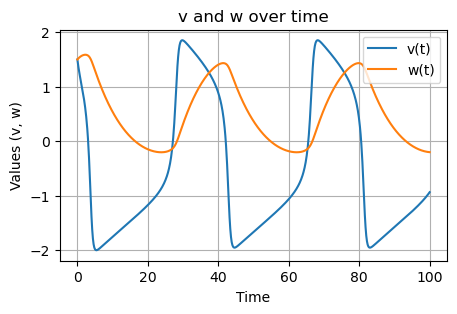

True


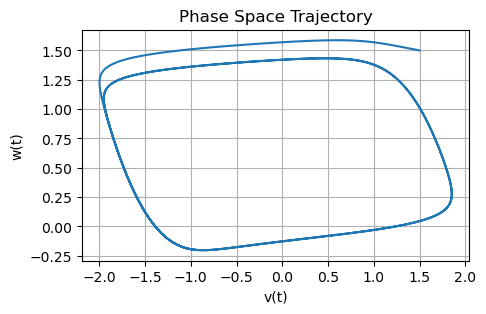

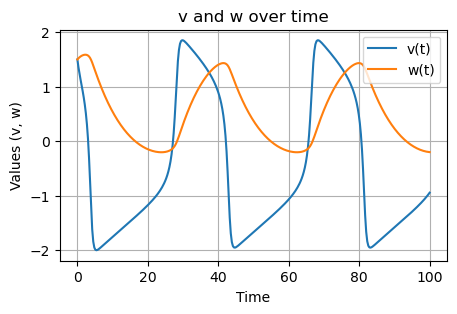

True


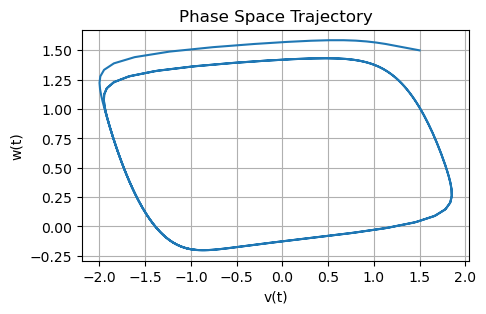

In [ ]:
i = 0
plot_trajectory(trajectories_batch[i,:,:], 0, T)
print(check_limit_cycle(trajectories_batch[i,:,:]))

plt.figure(figsize=(5, 3))
plt.plot(trajectories_batch[i,:,0],trajectories_batch[i,:,1], label='phase space')
plt.xlabel('v(t)')
plt.ylabel('w(t)')
plt.title('Phase Space Trajectory')
plt.grid(True)
plt.show()

plot_trajectory(trajectories_batch[i,::3,:], 0, T)
print(check_limit_cycle(trajectories_batch[i,:,:]))

plt.figure(figsize=(5, 3))
plt.plot(trajectories_batch[i,::3,0],trajectories_batch[i,::3,1], label='phase space')
plt.xlabel('v(t)')
plt.ylabel('w(t)')
plt.title('Phase Space Trajectory')
plt.grid(True)
plt.show()

In [5]:
cycle_persistence    = np.empty((0,2))
no_cycle_persistence = np.empty((0,2))

rips = Rips(verbose=False)

for i in range(trajectories_batch.shape[0]):
	if(check_limit_cycle(trajectories_batch[i,:,:])):
		cycle_persistence= np.append(cycle_persistence, extract_persistence(trajectories_batch[i,:,:],rips), axis=0)
	else:
		no_cycle_persistence=np.append(no_cycle_persistence, extract_persistence(trajectories_batch[i,:,:],rips), axis=0)

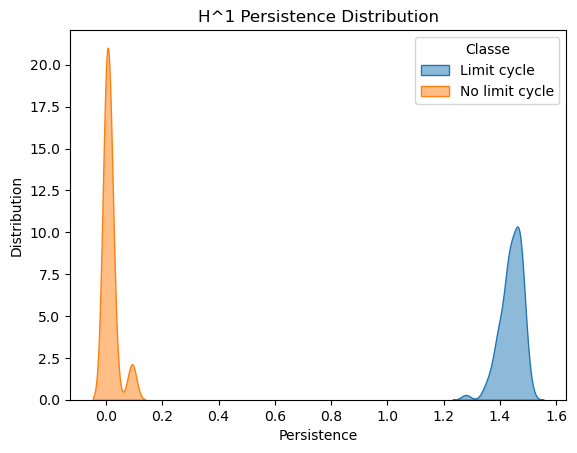

In [6]:
p1 = cycle_persistence[:,1]
p2 = no_cycle_persistence[:,1]

sns.kdeplot(p1, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^1 Persistence Distribution')
plt.show()

In [12]:
cycle_persistence_sliced    = np.empty((0,2))
no_cycle_persistence_sliced = np.empty((0,2))

p = 2

rips = Rips(verbose=False)

for i in range(trajectories_batch.shape[0]):
	if(check_limit_cycle(trajectories_batch[i,:,:])):
		cycle_persistence_sliced= np.append(cycle_persistence_sliced, extract_persistence(trajectories_batch[i,::p,:],rips), axis=0)
	else:
		no_cycle_persistence_sliced=np.append(no_cycle_persistence_sliced, extract_persistence(trajectories_batch[i,::p,:],rips), axis=0)

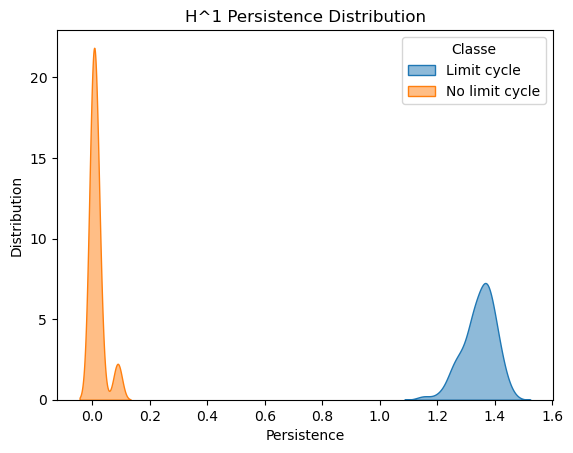

In [13]:
p1s = cycle_persistence_sliced[:,1]
p2s = no_cycle_persistence_sliced[:,1]

sns.kdeplot(p1s, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2s, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^1 Persistence Distribution')
plt.show()

In [11]:
distance = 0

for i in range(trajectories_batch.shape[0]):
    distance += persim.wasserstein(rips.transform(trajectories_batch[i,:,:])[1], rips.transform(trajectories_batch[i,::3,:])[1], matching=False)
distance /= trajectories_batch.shape[0]
print(distance)

0.3338977451150398


In [14]:
distance = 0

for i in range(trajectories_batch.shape[0]):
    distance += persim.wasserstein(rips.transform(trajectories_batch[i,:,:])[1], rips.transform(trajectories_batch[i,::2,:])[1], matching=False)
distance /= trajectories_batch.shape[0]
print(distance)

0.22145059565282996


In [ ]:
p1 = cycle_persistence[:,0]
p2 = no_cycle_persistence[:,0]

sns.kdeplot(p1, label='Limit cycle', fill=True, alpha=0.5)
sns.kdeplot(p2, label='No limit cycle', fill=True, alpha=0.5)

plt.xlabel('Persistence')
plt.ylabel('Distribution')
plt.legend(title='Classe')
plt.title('H^0 Persistence Distribution')
plt.show()

0.23466121405363083


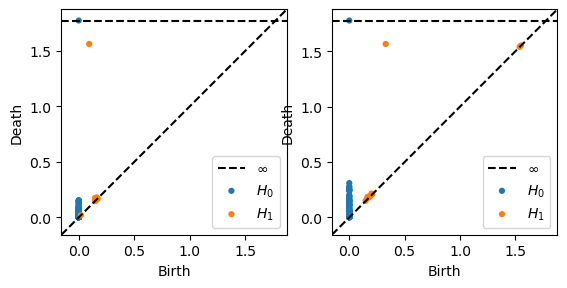

In [15]:
prova1 = rips.transform(trajectories_batch[0,:,:])
prova2 = rips.transform(trajectories_batch[0,::3,:])
plt.subplot(1, 2, 1)
rips.plot(prova1, show=False)
plt.subplot(1, 2, 2)
rips.plot(prova2, show=False)

print(persim.bottleneck(prova1[1], prova2[1], matching=False))

# TDA tools experiments

In [ ]:
from ripser import Rips

def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])

rips = Rips()
dgm  = rips.transform(trajectories_batch[0,:,:])
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm)}")

In [ ]:
data_clean = tadasets.dsphere(d=1, n=10, noise=0.0)
plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(data_clean[:,0], data_clean[:,1], label="clean data", s=8)
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
rips = Rips()
dgm  = rips.transform(data_clean)
rips.plot(show=True, title=f"Noisy\n{diagram_sizes(dgm)}")

In [ ]:
H0 = dgm[0]
persistences = H0[:,1] - H0[:,0]
persistences.sort()
np.max(persistences[:-1])

In [ ]:
from persim import PersLandscapeApprox, PersLandscapeExact
from persim.landscapes import plot_landscape_simple

pla = PersLandscapeApprox(dgms=dgm,hom_deg=0)
ax = plot_landscape_simple(pla, depth_range=range(10))